# FIIT Data Science Challenge

In [4]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Importing data
fiit_historic_raw= pd.read_csv('./data/workouts_history__fiit_club.csv', header = 0)
fiit_club_raw = pd.read_csv('./data/workouts__fiit_club.csv')

In [6]:
# Importing '.json' heart rate data
fiit_hb_raw = pd.read_json('./data/fiit_club_bpm_series.json')

## FIIT Club Data

In [7]:
# Inspecting FIIT CLUB data
print(fiit_club_raw.info())
fiit_club_raw.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   workout_id            283 non-null    int64  
 1   lesson_id             283 non-null    int64  
 2   user_id               283 non-null    int64  
 3   leaderboard_position  248 non-null    float64
 4   total_points          231 non-null    float64
 5   state                 283 non-null    object 
 6   app_type              283 non-null    object 
 7   app_tracker           250 non-null    object 
 8   studio_id             283 non-null    object 
 9   lesson_name           283 non-null    object 
 10  created_at            283 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 24.4+ KB
None


,count,mean,std,min,25%,50%,75%,max
workout_id,283.0,4.745876e+06,89.142123,4.745719e+06,4.745798e+06,4.745874e+06,4.745956e+06,4.746028e+06
lesson_id,283.0,1.394000e+03,0.000000,1.394000e+03,1.394000e+03,1.394000e+03,1.394000e+03,1.394000e+03
user_id,283.0,3.010917e+05,174053.564864,1.026000e+03,1.517025e+05,3.113530e+05,4.648790e+05,5.599240e+05
leaderboard_position,248.0,1.238306e+02,70.924687,1.000000e+00,6.250000e+01,1.245000e+02,1.862500e+02,2.320000e+02
total_points,231.0,1.429566e+03,308.713073,1.346792e+01,1.360841e+03,1.488939e+03,1.617760e+03,1.910400e+03


In [8]:
# Check leaderboard head
fiit_club_raw.head()

,workout_id,lesson_id,user_id,leaderboard_position,total_points,state,app_type,app_tracker,studio_id,lesson_name,created_at
0,4745837,1394,477774,1.0,1910.3999,COMPLETED,ios,TICKR X 6485,CARDIO,Intervals #36,2020-11-07T09:30:01.137Z
1,4745987,1394,12305,2.0,1869.0052,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07T09:30:11.522Z
2,4745915,1394,417904,3.0,1855.4762,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07T09:30:02.697Z
3,4745833,1394,259936,4.0,1810.2573,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07T09:30:01.118Z
4,4745876,1394,429685,5.0,1800.0208,COMPLETED,ios,TICKR X 49AE,CARDIO,Intervals #36,2020-11-07T09:30:01.588Z


In [9]:
# Split variables according to their types

# Categorical features
categorical = ['state', 'lesson_name', 'studio_id', 'app_type', 'app_tracker', 'type_of_class',
               'duration_range', 'gender', 'unit_system_preference', 'training_goal', 'activity_level']

# Numeric features
numeric = ['weight', 'height', 'user_age','min_recorded_hr', 'max_recorded_hr']

# Id features
ids = ['workout_id', 'lesson_id', 'user_id'] 

# Timestamp features
timestamps = ['created_at', 'registration_timestamp']

In [10]:
# Function to check counts and values of categorical variables
def counting_values(df, var_list, verbose = True):
    for col in var_list:
        try:
            series = None
            series = df[col]
            if verbose:
                print("Counts for '{}' variable:".format(col))
                print(series.value_counts(dropna = False))
                print()
        except:
            pass
    return series

# Call function on fiit_club_session
counting_values(fiit_club_raw,categorical)

Counts for 'state' variable:
COMPLETED    258
CANCELLED     17
QUIT           5
STARTED        3
Name: state, dtype: int64

Counts for 'lesson_name' variable:
Intervals #36    283
Name: lesson_name, dtype: int64

Counts for 'studio_id' variable:
CARDIO    283
Name: studio_id, dtype: int64

Counts for 'app_type' variable:
ios        250
android     33
Name: app_type, dtype: int64

Counts for 'app_tracker' variable:
APPLE_WATCH          66
NaN                  33
Versa 2               3
heart rate sensor     2
TICKR X 1BAB          1
                     ..
TICKR X E779          1
TICKR X 4998          1
TICKR X 2CB9          1
TICKR X D155          1
TICKR X 5B66          1
Name: app_tracker, Length: 183, dtype: int64



### Data Cleaning

- By inspecting leaderboard data we can identify 33 users without device that do not receive a leaderboard position so I will clean those intances because I am interested in those users scoring points during the competition. This leaves us with 248 data points.

- Additionally there were some users at the bottom of the table with null scores. Most of them `CANCELLED` their session before starting the workout so I assigned a 0 score to all of them. Some of them did `COMPLETE` the session but maybe they were not wearing the registered device and did not score any point.

- There were two users with non-null scores in last position, I will assume that the leaderboard is to be trusted and assigned them null scores for my analysis (as every other competetitor on the bottom of the table).

- Lastly I noticed that two users who started the competition and received valid leaderboard positions were not assigned any points. I decided to trust the leaderboard order once again and used `pandas.fillna()` function to input their scores with a `'bfill'` method and added a value of 0.0001 points to their scores. These users both had `STARTED` on ther session `'state'` feature, maybe this is somewhat related to them not getting a score.

- I will make a discussion on users `CANCELLING` (17) or `QUITING` (5) their sessions below while I plot the users scores.

In [11]:
%%capture
# Cleaning FIIT Club data
fiit_club = fiit_club_raw.dropna(subset=['leaderboard_position'])

# Casting dates to datetime objects
fiit_club['created_at'] = pd.to_datetime(fiit_club['created_at'])

# Identifying those finishing last
last_position = fiit_club['leaderboard_position'].values.max()

# Populating those in last position of leaderboard
fiit_club['total_points'].loc[fiit_club_raw.leaderboard_position == last_position] = 0

# Populating non-null missing scores 
mask = fiit_club['total_points'].isnull()
fiit_club['total_points'] = fiit_club['total_points'].fillna(method = 'bfill')
fiit_club['total_points'].loc[mask] += 0.0001 

In [12]:
# Check cleaned DataFrame info
print(fiit_club.info())
fiit_club.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 0 to 247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   workout_id            248 non-null    int64              
 1   lesson_id             248 non-null    int64              
 2   user_id               248 non-null    int64              
 3   leaderboard_position  248 non-null    float64            
 4   total_points          248 non-null    float64            
 5   state                 248 non-null    object             
 6   app_type              248 non-null    object             
 7   app_tracker           248 non-null    object             
 8   studio_id             248 non-null    object             
 9   lesson_name           248 non-null    object             
 10  created_at            248 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(5)
memory usage

,count,mean,std,min,25%,50%,75%,max
workout_id,248.0,4.745871e+06,88.512033,4745719.0,4.745794e+06,4.745868e+06,4.745950e+06,4.746028e+06
lesson_id,248.0,1.394000e+03,0.000000,1394.0,1.394000e+03,1.394000e+03,1.394000e+03,1.394000e+03
user_id,248.0,2.923845e+05,174157.941882,1026.0,1.449838e+05,3.041790e+05,4.605358e+05,5.599240e+05
leaderboard_position,248.0,1.238306e+02,70.924687,1.0,6.250000e+01,1.245000e+02,1.862500e+02,2.320000e+02
total_points,248.0,1.335729e+03,461.195905,0.0,1.293179e+03,1.472225e+03,1.601952e+03,1.910400e+03


In [13]:
# Check clean fiit_club dataset head
fiit_club.head()

,workout_id,lesson_id,user_id,leaderboard_position,total_points,state,app_type,app_tracker,studio_id,lesson_name,created_at
0,4745837,1394,477774,1.0,1910.3999,COMPLETED,ios,TICKR X 6485,CARDIO,Intervals #36,2020-11-07 09:30:01.137000+00:00
1,4745987,1394,12305,2.0,1869.0052,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07 09:30:11.522000+00:00
2,4745915,1394,417904,3.0,1855.4762,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07 09:30:02.697000+00:00
3,4745833,1394,259936,4.0,1810.2573,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07 09:30:01.118000+00:00
4,4745876,1394,429685,5.0,1800.0208,COMPLETED,ios,TICKR X 49AE,CARDIO,Intervals #36,2020-11-07 09:30:01.588000+00:00


### Exploratory Data Analysis

- We can plot a histogram of scores and identify a Skewed distribution with a long tail to the left on smaller values 
- If we analize those users scoring less than 500 points we realize that out of 22 instances: <br />
    o 15 people cancelled the session (out of a total of 17 CANCELLED sessions) <br />
    o 1 person quitted (out of 6 QUIT sessions) <br />
    o 6 completed it with low performance <br />
- I will cut scores under 500 as to approximate meaningful completed sessions and to also lower the Skewness in my Score distribution
- Note I also tried cutpoints scores of 750 and 1000 but that only increased the amount of COMPLETED sessions discarded (up to 13). I'd rather just assume that those people were low performance user not to lose more data.
- I plotted the results on a 25 bins Histogram in the range 0 to 2000 (based on max-min scores observed during the session)

In [14]:
# Function to build Histograms
def build_histogram(df, column, bins = 25, norm = True, rang = [0,1], label = "Distribution"):
    # Filter range based on Min-Max scores
    rango = rang

    # Seaborn plot
    plt.figure(figsize=[15,8])
    sns.set_style("darkgrid")
    sns.distplot(df[column], bins=bins, hist=True, color = 'b', hist_kws ={"range": rango}, 
                 kde_kws={'clip': rango}, norm_hist=norm, axlabel=label, label=None)
    plt.xlabel(label, fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

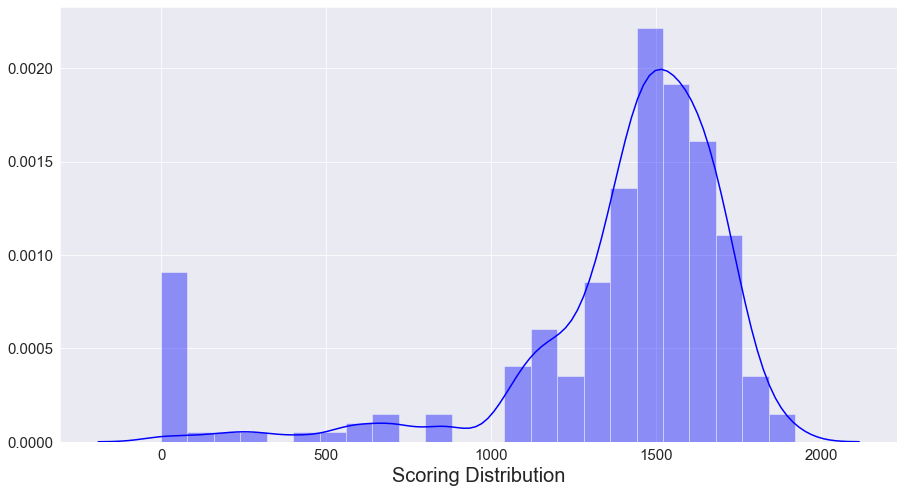

In [15]:
# Plot a Point Histogram

# Range based on points Min-Max scores (see df stats!)
rango = [0,2000]

# Build Histogram
build_histogram(fiit_club, 'total_points', bins = 25, norm = True, rang = rango, label = "Scoring Distribution")

In [16]:
# Check those users scoring less than cutpoint
cutpoint = 500
low_scores = fiit_club.loc[fiit_club.total_points < cutpoint]
counting_values(low_scores,['state'])

# Cleaner data
fiit_club = fiit_club.loc[fiit_club.total_points > cutpoint]
print(fiit_club.info())
fiit_club.describe()

Counts for 'state' variable:
CANCELLED    15
COMPLETED     6
QUIT          1
Name: state, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 0 to 225
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   workout_id            226 non-null    int64              
 1   lesson_id             226 non-null    int64              
 2   user_id               226 non-null    int64              
 3   leaderboard_position  226 non-null    float64            
 4   total_points          226 non-null    float64            
 5   state                 226 non-null    object             
 6   app_type              226 non-null    object             
 7   app_tracker           226 non-null    object             
 8   studio_id             226 non-null    object             
 9   lesson_name           226 non-null    object             
 10  created_at            226 non-

,workout_id,lesson_id,user_id,leaderboard_position,total_points
count,2.260000e+02,226.0,226.000000,226.000000,226.000000
mean,4.745865e+06,1394.0,288391.172566,113.367257,1460.838630
std,8.821248e+01,0.0,176977.619240,65.439387,234.521635
min,4.745719e+06,1394.0,1026.000000,1.000000,554.075130
25%,4.745789e+06,1394.0,121525.250000,57.250000,1373.966100
50%,4.745856e+06,1394.0,301332.000000,113.000000,1492.447250
75%,4.745941e+06,1394.0,459549.250000,169.750000,1620.851750
max,4.746028e+06,1394.0,559924.000000,226.000000,1910.399900


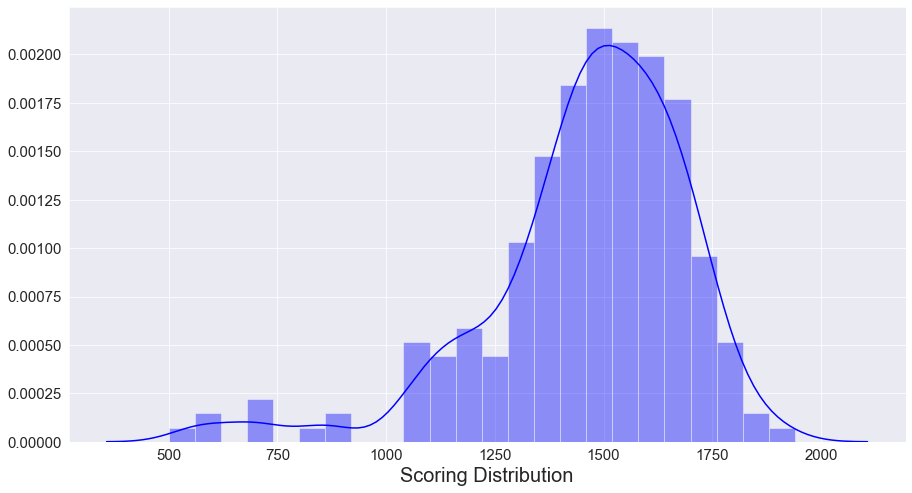

In [17]:
# Plot a Cleaner Point Histogram

# Range based on points Min-Max scores (see df stats!)
rango = [cutpoint,2000]

# Build Histogram
build_histogram(fiit_club, 'total_points', bins = 25, norm = True, rang = rango, label = "Scoring Distribution")

## Modeling: KMeans Clustering

#### I will expand my original `fiit_club` DataFrame by adding numeric features that could be useful to do some cluster analysis

- Some options we could consider are: `bpm` (from `.json` file), `user_age`, `min_recorded_hr`, `max_recorded_hr`,  `recency`, `frecuency`.
- I chose to work with: `mean_bpm` , `user_age` , `score` to cluster my data.
- In order to obtain `mean_bpm` I used heart rate data from `.json` file. I could have used `median`, `min` or `max` bpm as well. While chosing the variables I tried to keep in mind the following statement: 

``` In Fiit Club, users compete and receive points the harder the effort they put in. In order to participate, users need to wear a compatible heart rate device and once the warm up of the class is over, users will start accumulating points up until the start of the cool down period. Points are granted according to the value of the heart rate’s user as a percentage of their heart rate reserve.
```

- I wanted to keep my model simple. Adding more variables would just have made my model more difficult to interpret and visualize.
- Once we get a simple model we can always add more variables and/or substract others.

In [18]:
# Expand FIIT Club DataFrame with BPMs data from '.json' file
bpm_df = pd.merge(left = fiit_club, right = fiit_hb_raw, left_on = 'workout_id', right_on = 'workout_id' , how = 'left')
# print(bpm_df.info())
bpm_df.head()

,workout_id,lesson_id,user_id,leaderboard_position,total_points,state,app_type,app_tracker,studio_id,lesson_name,created_at,bpm
0,4745837,1394,477774,1.0,1910.3999,COMPLETED,ios,TICKR X 6485,CARDIO,Intervals #36,2020-11-07 09:30:01.137000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:11.1...
1,4745987,1394,12305,2.0,1869.0052,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07 09:30:11.522000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:31.1...
2,4745915,1394,417904,3.0,1855.4762,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07 09:30:02.697000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:15.5...
3,4745833,1394,259936,4.0,1810.2573,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07 09:30:01.118000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:11.3...
4,4745876,1394,429685,5.0,1800.0208,COMPLETED,ios,TICKR X 49AE,CARDIO,Intervals #36,2020-11-07 09:30:01.588000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:11.9...


In [19]:
# Define a function to get the mean value of bpms registered during FIIT Club Session
def sum_list_of_dict(total):
    return sum(d['value'] for d in total) / len(total)

# Add a column to DataFrame with mean bpms on that workout
bpm_df['mean_bpm'] = bpm_df['bpm'].apply(sum_list_of_dict)
print('Max mean bpm: {}'.format(bpm_df['mean_bpm'].max()))
print('Min mean bpm: {}'.format(bpm_df['mean_bpm'].min()))
bpm_df.head()

Max mean bpm: 179.98164594434576
Min mean bpm: 105.13050440352282


,workout_id,lesson_id,user_id,leaderboard_position,total_points,state,app_type,app_tracker,studio_id,lesson_name,created_at,bpm,mean_bpm
0,4745837,1394,477774,1.0,1910.3999,COMPLETED,ios,TICKR X 6485,CARDIO,Intervals #36,2020-11-07 09:30:01.137000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:11.1...,169.434080
1,4745987,1394,12305,2.0,1869.0052,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07 09:30:11.522000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:31.1...,167.866640
2,4745915,1394,417904,3.0,1855.4762,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07 09:30:02.697000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:15.5...,179.981646
3,4745833,1394,259936,4.0,1810.2573,COMPLETED,ios,APPLE_WATCH,CARDIO,Intervals #36,2020-11-07 09:30:01.118000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:11.3...,158.614492
4,4745876,1394,429685,5.0,1800.0208,COMPLETED,ios,TICKR X 49AE,CARDIO,Intervals #36,2020-11-07 09:30:01.588000+00:00,[{'recorded_timestamp': '2020-11-07 09:30:11.9...,161.482786


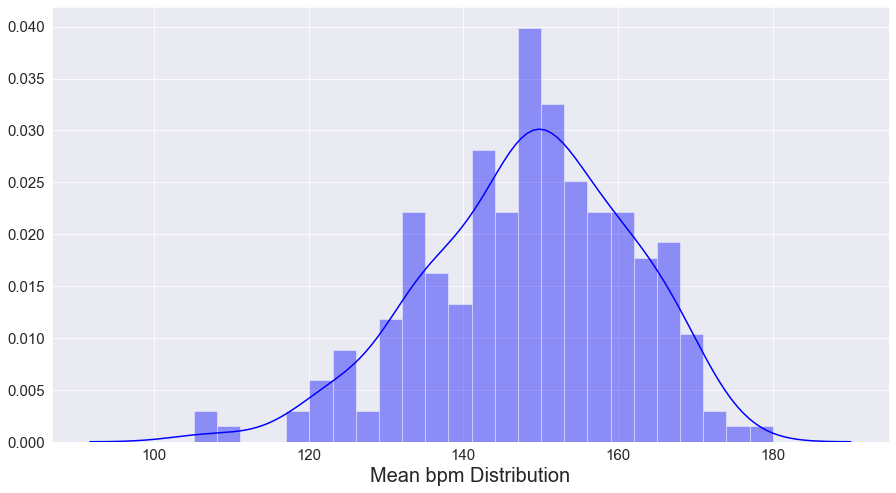

In [20]:
# Plot a Mean_BPM Histogram

# Range based on points Min-Max scores (see df stats!)
rango = [bpm_df['mean_bpm'].min(),bpm_df['mean_bpm'].max()]

# Build Histogram
build_histogram(bpm_df, 'mean_bpm', bins = 25, norm = True, rang = rango, label = "Mean bpm Distribution")

In [21]:
# Expand DataFrame once again with BPMs data from '.json' file
interm_df = pd.merge(left = bpm_df, right = fiit_historic_raw, left_on = 'workout_id', right_on = 'workout_id' , how = 'left')

# Print columns
print(interm_df.columns)

# Head of the intermediate DataFrame
interm_df.head().transpose()

Index(['workout_id', 'lesson_id_x', 'user_id_x', 'leaderboard_position',
       'total_points', 'state_x', 'app_type_x', 'app_tracker_x', 'studio_id_x',
       'lesson_name_x', 'created_at_x', 'bpm', 'mean_bpm', 'lesson_id_y',
       'user_id_y', 'created_at_y', 'state_y', 'lesson_name_y', 'studio_id_y',
       'app_type_y', 'app_tracker_y', 'type_of_class', 'duration_range',
       'gender', 'weight', 'height', 'user_age', 'unit_system_preference',
       'training_goal', 'registration_timestamp', 'activity_level',
       'min_recorded_hr', 'max_recorded_hr'],
      dtype='object')


,0,1,2,3,4
workout_id,4745837,4745987,4745915,4745833,4745876
lesson_id_x,1394,1394,1394,1394,1394
user_id_x,477774,12305,417904,259936,429685
leaderboard_position,1,2,3,4,5
total_points,1910.4,1869.01,1855.48,1810.26,1800.02
state_x,COMPLETED,COMPLETED,COMPLETED,COMPLETED,COMPLETED
app_type_x,ios,ios,ios,ios,ios
app_tracker_x,TICKR X 6485,APPLE_WATCH,APPLE_WATCH,APPLE_WATCH,TICKR X 49AE
studio_id_x,CARDIO,CARDIO,CARDIO,CARDIO,CARDIO
lesson_name_x,Intervals #36,Intervals #36,Intervals #36,Intervals #36,Intervals #36


In [22]:
model_df = interm_df.drop(['workout_id', 'lesson_id_x', 'user_id_x', 'leaderboard_position', \
                           'state_x', 'app_type_x', 'app_tracker_x', 'studio_id_x', \
                           'lesson_name_x', 'created_at_x', 'bpm', 'lesson_id_y', \
                           'user_id_y', 'created_at_y', 'state_y', 'lesson_name_y', 'studio_id_y', \
                           'app_type_y', 'app_tracker_y', 'type_of_class', 'duration_range', \
                           'gender', 'weight', 'height', 'unit_system_preference', \
                           'training_goal', 'registration_timestamp', 'activity_level', \
                           'min_recorded_hr', 'max_recorded_hr'], axis = 1)

model_df.head()

,total_points,mean_bpm,user_age
0,1910.3999,169.434080,22.0
1,1869.0052,167.866640,35.0
2,1855.4762,179.981646,22.0
3,1810.2573,158.614492,34.0
4,1800.0208,161.482786,24.0


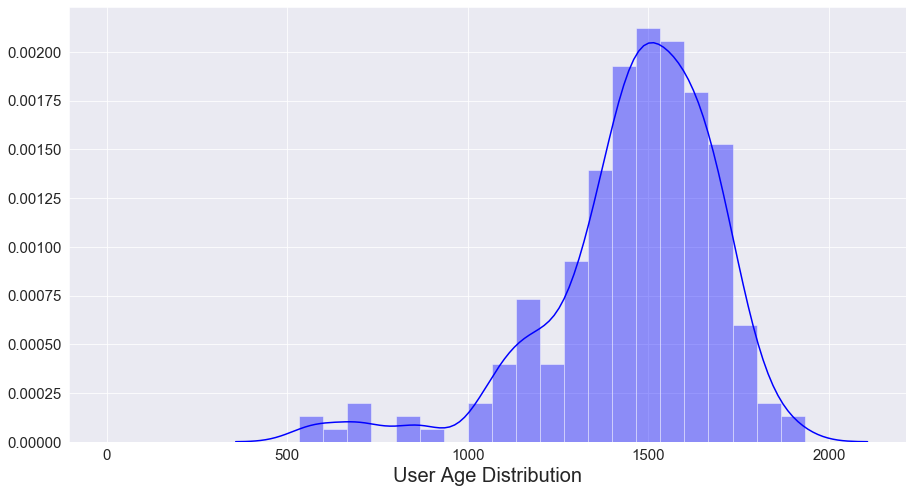

In [23]:
# Plot a User Age Histogram

# Range based on points Min-Max ages (see df stats!)
rango = [0,2000]

# Build Histogram
build_histogram(model_df, 'total_points', bins = 30, norm = True, rang = rango, label = "User Age Distribution")

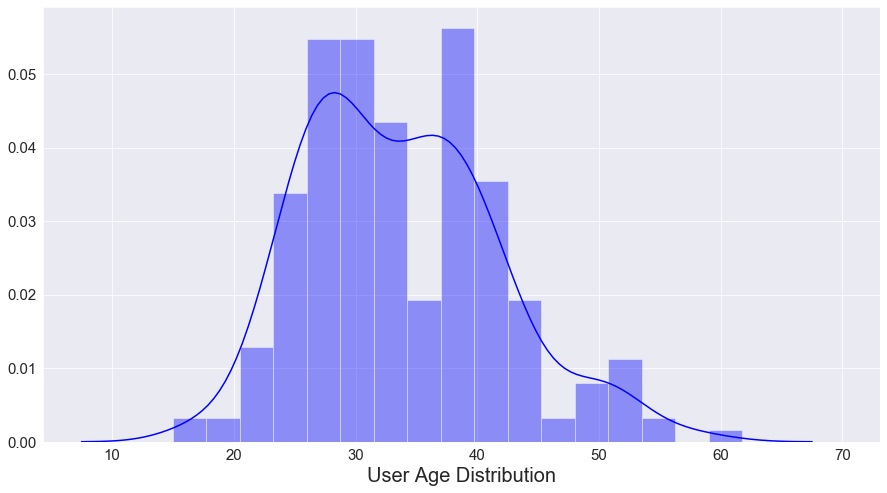

In [24]:
# Plot a User Age Histogram

# Range based on points Min-Max ages (see df stats!)
rango = [15,70]

# Build Histogram
build_histogram(model_df, 'user_age', bins = 20, norm = True, rang = rango, label = "User Age Distribution")

### KMeans Clustering Requirements

#### We will have to make certain considerations before constructing our Clustering Model

- First step in the segmentation process is to pre-process the data. I will apply log transformation to reduce de skwness present in the distribution of chosen variables 
- Secondly I will normalize the data to prepare it for clustering with `scikit-learn` `StandardScaler()`
- I will check my variables have distributions that are roughly normal
- Then I will plot the sum of squared errors for each value of k and identify if there is an elbow. This will guide me towards the recommended number of clusters to use.

In [25]:
# Import StandardScaler 
from sklearn.preprocessing import StandardScaler

# Apply log transformation
model_df_log = np.log(model_df)

# Initialize StandardScaler and fit it 
scaler = StandardScaler()
scaler.fit(model_df_log)

# Transform and store the scaled data as model_df_normalized
model_np_normalized = scaler.transform(model_df_log)

# Notice our features are scaled
normal_df = pd.DataFrame(model_np_normalized, columns = ['total_points','mean_bpm','user_age'])
normal_df.describe()

,total_points,mean_bpm,user_age
count,2.260000e+02,2.260000e+02,2.260000e+02
mean,2.656675e-15,-7.655626e-15,-1.475712e-15
std,1.002220e+00,1.002220e+00,1.002220e+00
min,-4.930277e+00,-3.636131e+00,-3.063487e+00
25%,-2.329265e-01,-5.959995e-01,-7.901316e-01
50%,1.949115e-01,1.026303e-01,2.800438e-02
75%,6.218137e-01,7.175383e-01,6.304797e-01
max,1.471955e+00,2.123465e+00,2.509289e+00


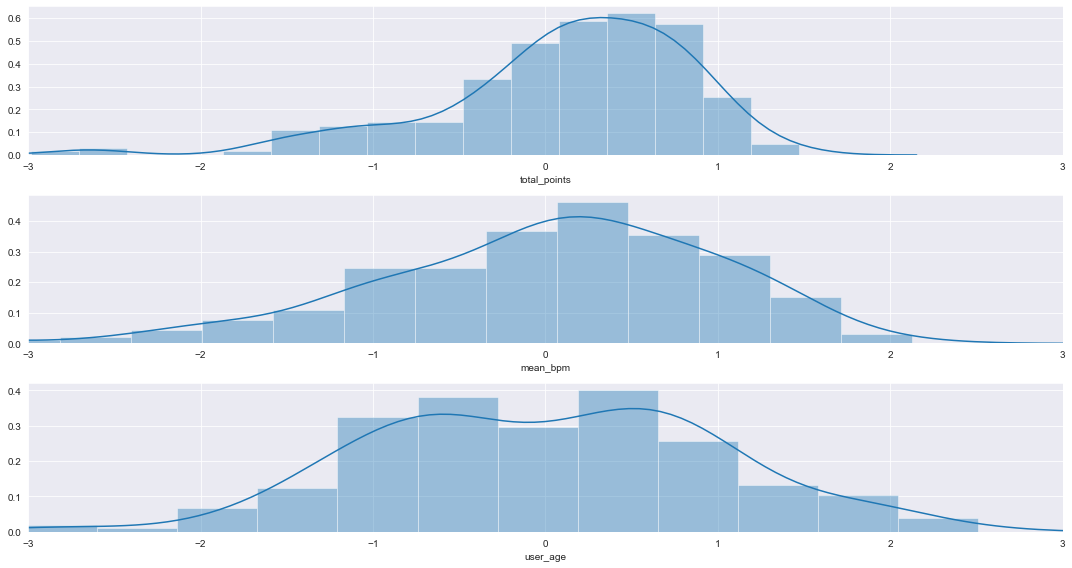

In [26]:
# Checking that our Standarized Variables are roughly normally distributed
fig = plt.figure(figsize=[15,8])

# Create a subplot of the distribution of 'total_points'
plt.subplot(3, 1, 1); sns.distplot(normal_df['total_points'])
plt.xlim(-3,3)

# Create a subplot of the distribution of 'mean_bpm'
plt.subplot(3, 1, 2); sns.distplot(normal_df['mean_bpm'])
plt.xlim(-3,3)

# Create a subplot of the distribution of 'user_age'
plt.subplot(3, 1, 3); sns.distplot(normal_df['user_age'])
plt.xlim(-3,3)

# Show plots
fig.tight_layout()
plt.show()

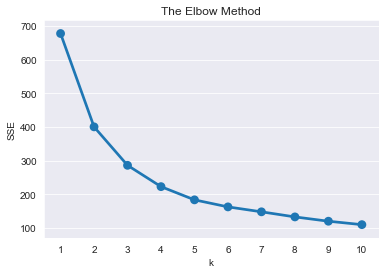

In [27]:
# Import KMeans module
from sklearn.cluster import KMeans
sse = {}

# Fit KMeans and calculate SSE for each k between 1 and 10
for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1).fit(model_np_normalized)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_   

# Add the plot title, x and y axis labels
plt.title('The Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

#### We can visualize an elbow somewhere between 3 - 4 clusters. I will build a model with 4 Clusters

In [28]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(model_np_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a new DataFrame by adding a cluster label column to datamart_rfmt
fiit_club_k4 = model_df.assign(label=cluster_labels)

# Group by cluster
grouped = fiit_club_k4.groupby(['label'])

# Calculate average RFMT values and segment sizes for each cluster
grouped.agg({
    'total_points': 'mean',
    'mean_bpm': 'mean',
    'user_age': ['mean', 'count']
  }).round(1)

total_points mean_bpm user_age      
              mean     mean     mean count
label                                     
0            714.4    121.8     36.7     9
1           1571.5    156.5     26.8    94
2           1566.9    152.3     39.5    66
3           1273.3    134.0     38.0    57

In [29]:
# Top scorers
fiit_club_k4.head(10)

,total_points,mean_bpm,user_age,label
0,1910.3999,169.434080,22.0,1
1,1869.0052,167.866640,35.0,2
2,1855.4762,179.981646,22.0,1
3,1810.2573,158.614492,34.0,2
4,1800.0208,161.482786,24.0,1
5,1799.1444,159.279359,28.0,1
6,1773.3670,154.735312,43.0,2
7,1772.4712,170.984187,25.0,1
8,1764.3152,169.357157,40.0,2
9,1763.3688,157.613491,40.0,2


In [30]:
fiit_club_k4.tail(10)

,total_points,mean_bpm,user_age,label
216,1041.37540,123.869334,48.0,3
217,872.65900,117.163311,41.0,0
218,865.21750,109.280224,39.0,0
219,845.93580,120.888176,33.0,0
220,705.27924,136.540020,43.0,0
221,704.32770,105.130504,38.0,0
222,703.92400,105.717631,37.0,0
223,602.94870,141.427354,31.0,0
224,575.65320,117.515516,44.0,0
225,554.07513,142.819071,24.0,0


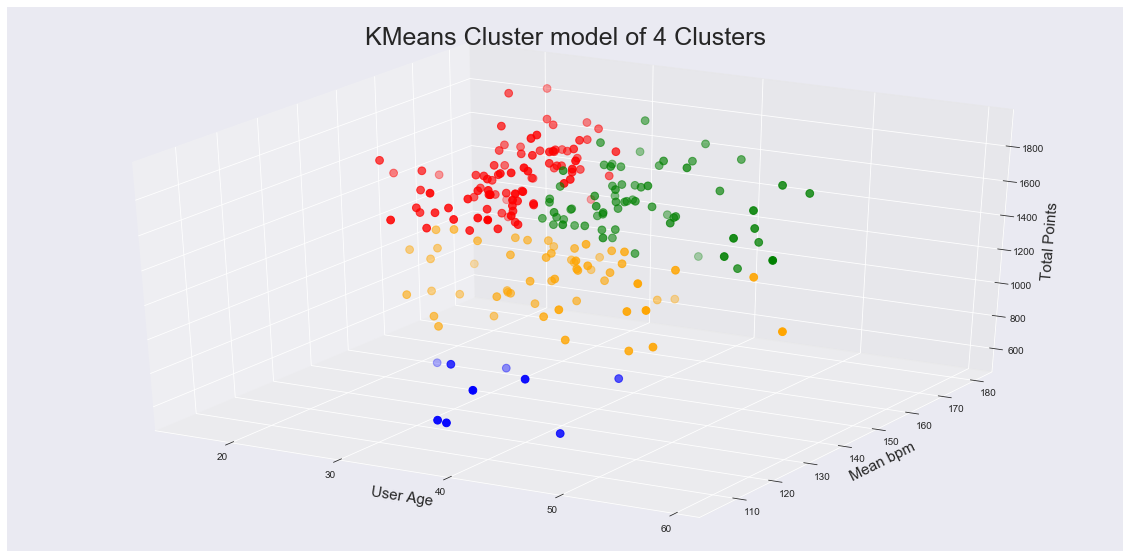

In [31]:
from mpl_toolkits.mplot3d import Axes3D

df = fiit_club_k4.copy()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.user_age[df.label == 0], df["mean_bpm"][df.label == 0], df["total_points"][df.label == 0], c='blue', s=60)
ax.scatter(df.user_age[df.label == 1], df["mean_bpm"][df.label == 1], df["total_points"][df.label == 1], c='red', s=60)
ax.scatter(df.user_age[df.label == 2], df["mean_bpm"][df.label == 2], df["total_points"][df.label == 2], c='green', s=60)
ax.scatter(df.user_age[df.label == 3], df["mean_bpm"][df.label == 3], df["total_points"][df.label == 3], c='orange', s=60)

plt.xlabel("User Age", fontsize = 15)
plt.ylabel("Mean bpm", fontsize = 15)
ax.set_title('KMeans Cluster model of 4 Clusters', fontsize = 25)
ax.set_zlabel('Total Points', fontsize = 15)
# ax.view_init(30, 150)
plt.show()

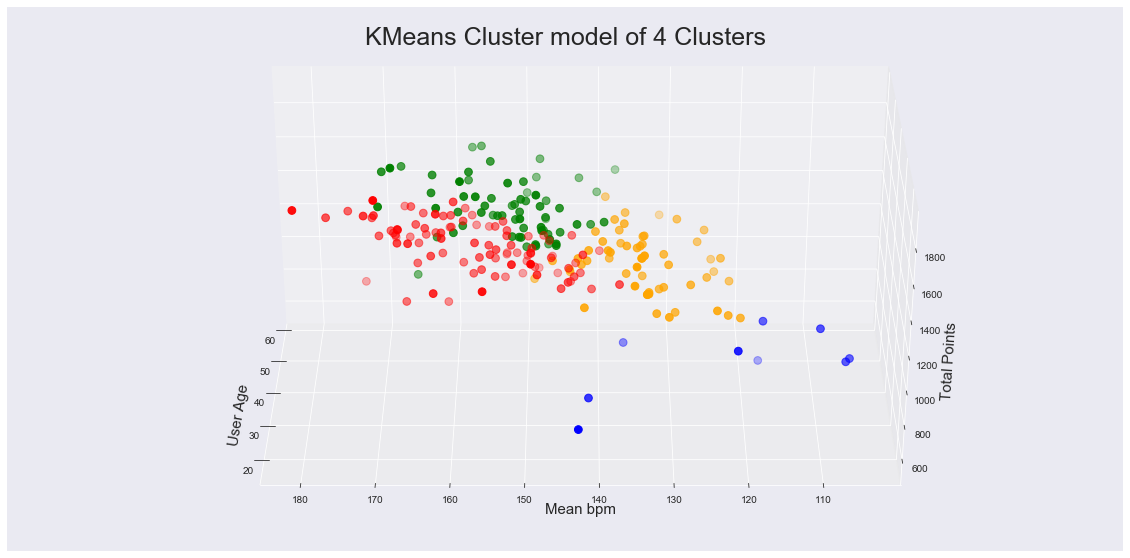

In [32]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.user_age[df.label == 0], df["mean_bpm"][df.label == 0], df["total_points"][df.label == 0], c='blue', s=60)
ax.scatter(df.user_age[df.label == 1], df["mean_bpm"][df.label == 1], df["total_points"][df.label == 1], c='red', s=60)
ax.scatter(df.user_age[df.label == 2], df["mean_bpm"][df.label == 2], df["total_points"][df.label == 2], c='green', s=60)
ax.scatter(df.user_age[df.label == 3], df["mean_bpm"][df.label == 3], df["total_points"][df.label == 3], c='orange', s=60)

plt.xlabel("User Age", fontsize = 15)
plt.ylabel("Mean bpm", fontsize = 15)
ax.set_title('KMeans Cluster model of 4 Clusters', fontsize = 25)
ax.set_zlabel('Total Points', fontsize = 15)
ax.view_init(30, 180)
plt.show()

# RESTA ANALIZAR QUIENES SON LOS GANADORES

- Analize KMeans cluster results
- Do some analysis over winners and losers: <br/>
    o How do their categorical features distributions look like with respect to the mean values? <br/>
    o How do their summary statistics compare with respect to the general ones?
    
- Add a section on how to improve the model <br/>
    o May be worth to separate results for MALE / FEMALES as their optimal `bpm` zones might differ -> We lose data <br/>
    o We might also break 

## FIIT historical data

In [33]:
# Inspecting FIIT historical data
print(fiit_historic_raw.info())
fiit_historic_raw.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54328 entries, 0 to 54327
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   workout_id              54328 non-null  int64  
 1   lesson_id               54328 non-null  int64  
 2   user_id                 54328 non-null  int64  
 3   created_at              54328 non-null  object 
 4   state                   54328 non-null  object 
 5   lesson_name             54328 non-null  object 
 6   studio_id               54328 non-null  object 
 7   app_type                54328 non-null  object 
 8   app_tracker             38422 non-null  object 
 9   type_of_class           54328 non-null  object 
 10  duration_range          54328 non-null  object 
 11  gender                  53998 non-null  object 
 12  weight                  53665 non-null  float64
 13  height                  53665 non-null  float64
 14  user_age                50012 non-null

,count,mean,std,min,25%,50%,75%,max
workout_id,54328.0,2.928815e+06,1.359798e+06,5150.0,1797476.25,3310551.5,4071348.0,4792096.0
lesson_id,54328.0,8.469615e+02,4.070199e+02,25.0,516.00,956.0,1178.0,1500.0
user_id,54328.0,2.037635e+05,1.538170e+05,1026.0,63592.00,168875.0,316971.0,559924.0
weight,53665.0,6.870807e+01,1.331340e+01,47.0,59.40,66.7,73.5,154.2
height,53665.0,1.665306e+02,8.508957e+00,90.0,162.00,166.0,170.0,196.0
user_age,50012.0,3.364247e+01,8.610798e+00,15.0,27.00,33.0,39.0,59.0
min_recorded_hr,40650.0,7.713026e+01,1.516412e+01,0.0,67.00,77.0,87.0,165.0
max_recorded_hr,40650.0,1.523096e+02,3.079553e+01,44.0,129.00,163.0,176.0,229.0


In [34]:
fiit_historic_raw.head(5).transpose()

,0,1,2,3,4
workout_id,444573,1980354,829353,3231659,585654
lesson_id,170,1065,422,1021,96
user_id,12936,158761,15301,63116,116828
created_at,2019-04-07T18:53:00.288+01:00,2020-04-23T19:04:19.658+01:00,2019-09-11T12:34:50.023+01:00,2020-07-02T08:44:04.903+01:00,2019-06-04T19:20:43.436+01:00
state,COMPLETED,COMPLETED,COMPLETED,CANCELLED,COMPLETED
lesson_name,Intervals #11,Nonstop #2,Full Body Stretch #3,Blaze #1,Circuits #46
studio_id,CARDIO,CARDIO,REBALANCE,STRENGTH,CARDIO
app_type,ios,ios,ios,ios,ios
app_tracker,NaN,FIIT 38A748,TICKR X F6FB,NaN,NaN
type_of_class,INDIVIDUAL,INDIVIDUAL,INDIVIDUAL,INDIVIDUAL,INDIVIDUAL


## Summary of insights from Exploratory Data Analysis (EDA)

- The percentage of `COMPLETED` workouts in the analyzed sample was 88%
- Five most popular lessons observed were: `Full Body Stretch #2`, `Mobility Flow #12`,`Full Body Stretch #3`,`Upper Body Stretch #2`,`Full Body Stretch #4`
- From all observed workouts: 47% belong to `CARDIO` studio, 30% to `REBALANCE` studio and 24% to `STRENGTH` studio
- Most FIIT workouts observed were performed on `iOS` (89%) and a relatively small amount on  `Android` (10%). Other platforms constitute the remaining 1%.
- The observed type of classes distribution was: 83% `INDIVIDUAL` Classes, 15% `FIIT_CLUB` classes and 2%  of `PRIVATE_GROUP  ` 
- From FIIT (unique) observed users : 52% reported `LOSE_WEIGHT` goals, 23% `GENERAL` goals , 22% `BUILD MUSCLE` goals , 2% `FLEXIBILITY` goals and 1% `POSTNATAL` goals.
- From FIIT (unique) observed users : 64% reported `MEDIUM` activity level, 25% `HIGH` activity level , 22% `LOW` activity level and 1% `POSTNATAL` activity level.
- The distribution of activitiy duration as grouped by `lesson_id` observed was: 72.0 % for `ABOUT_25_MINUTES` activities, 22.0 % for `ABOUT_40_MINUTES` activities and 6% for `ABOUT_10_MINUTES` activities.


In [35]:
%%capture
# Assign historic data to generic DataFrame
df = fiit_historic_raw
users_df = df.groupby('user_id')['weight','height','user_age', 'gender'].first()

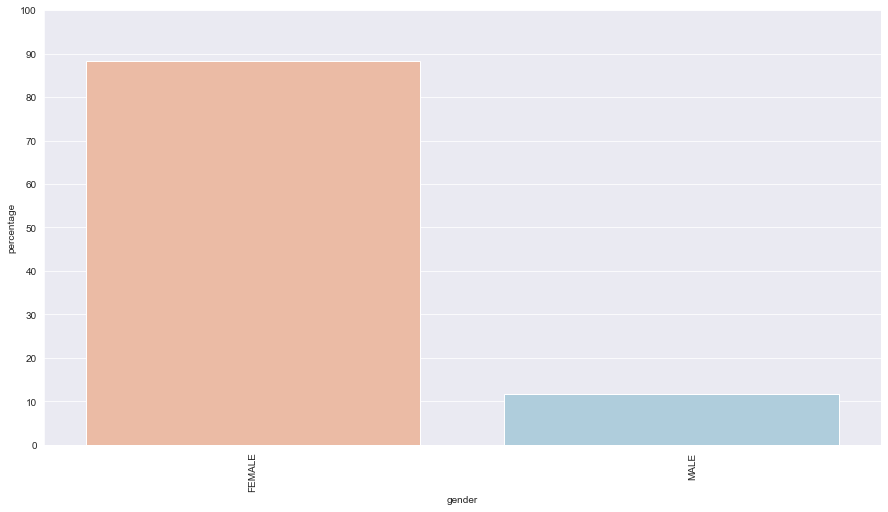

FEMALE    0.882143
MALE      0.117857
Name: gender, dtype: float64

In [36]:
# Gender distribution plot
gender_df = (users_df['gender']
                     .value_counts(normalize=True)
                     .mul(100)
                     .reset_index())
gender_df.columns = ['gender', 'percentage']

plt.figure(figsize=[15,8])
sns.barplot(x='gender', y='percentage', data=gender_df, palette='RdBu')
plt.xticks([0,1.05], df['gender'].unique(), rotation = 'vertical')
plt.yticks(range(0,101,10))
plt.show()

users_df['gender'].value_counts(normalize=True)

In [37]:
# Analizing percentage of completed classes 
serie_state = counting_values(df,['state'], verbose = False)
print(serie_state.value_counts())
completed = 100*serie_state.value_counts()/serie_state.value_counts().sum()
print("Percentage of completed classes {}".format(round(completed[0]),1))

COMPLETED    47975
CANCELLED     4669
QUIT          1059
STARTED        625
Name: state, dtype: int64
Percentage of completed classes 88.0


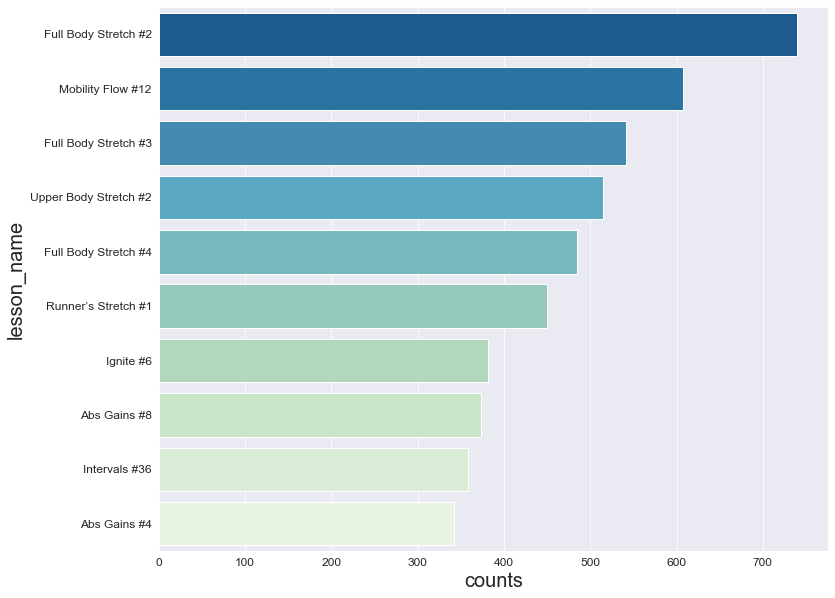

In [38]:
# Plotting ten most popular training sessions
num_vars = range(0,10)

# Lessons Count plot
plt.figure(figsize=[12,10])
sns.countplot(y='lesson_name', data=df, palette='GnBu_r', order = df['lesson_name'].value_counts().iloc[num_vars].index)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel("counts", fontsize=20)
plt.ylabel("lesson_name", fontsize=20)
plt.show()

# Analizing most popular training sessions 
#serie_lessons = counting_values(df,['lesson_name'], verbose = False)
# print(serie_lessons.value_counts())
#serie_lessons = serie_lessons.value_counts()/(serie_lessons.value_counts().sum())
# print("Popular Lessons by percentage {}".format(serie_lessons,'0.2f'))

In [39]:
# Analizing percentage of workouts by `studio_id`
serie_studio = counting_values(df,['studio_id'], verbose = False)
print(serie_studio.value_counts())
studio = 100*serie_studio.value_counts()/serie_studio.value_counts().sum()
print("Percentage of CARDIO {}".format(round(studio[0]),1))
print("Percentage of REBALANCE {}".format(round(studio[1]),1))
print("Percentage of STRENGTH {}".format(round(studio[2]),1))

CARDIO       25311
REBALANCE    16062
STRENGTH     12955
Name: studio_id, dtype: int64
Percentage of CARDIO 47.0
Percentage of REBALANCE 30.0
Percentage of STRENGTH 24.0


In [40]:
# Analizing percentage of users by `app`
serie_app = counting_values(df,['app_type'], verbose = False)
print(serie_app.value_counts())
app = 100*serie_app.value_counts()/serie_app.value_counts().sum()
print("Percentage of iOS users {}".format(round(app[0]),1))
print("Percentage of Android users {}".format(round(app[1]),1))
print("Percentage of Sky users {} ".format(round(app[2]),1))
print("Percentage of Amazon users {} ".format(round(app[2]),1))

ios        48346
android     5699
sky          220
amazon        63
Name: app_type, dtype: int64
Percentage of iOS users 89.0
Percentage of Android users 10.0
Percentage of Sky users 0.0 
Percentage of Amazon users 0.0 


In [41]:
# Analizing percentage of users by `type_of_class`
serie_class = counting_values(df,['type_of_class'], verbose = False)
print(serie_class.value_counts())
classes = 100*serie_class.value_counts()/serie_class.value_counts().sum()
print("Percentage of INDIVIDUAL classes {}".format(round(classes[0]),1))
print("Percentage of FIIT CLUB classes {}".format(round(classes[1]),1))
print("Percentage of PRIVATE_GROUP classess {} ".format(round(classes[2]),1))


INDIVIDUAL       45166
FIIT_CLUB         8195
PRIVATE_GROUP      967
Name: type_of_class, dtype: int64
Percentage of INDIVIDUAL classes 83.0
Percentage of FIIT CLUB classes 15.0
Percentage of PRIVATE_GROUP classess 2.0 


In [42]:
# Analizing percentage of users by `training_goal`
# Notice we first must group not to repeat users
serie_goal = df.groupby('user_id')['training_goal'].first()
print(serie_goal.value_counts())
goal = 100*serie_goal.value_counts()/serie_goal.value_counts().sum()
print("Percentage of LOSE_WEIGHT goals {}".format(round(goal[0]),1))
print("Percentage of GENERAL use goals {}".format(round(goal[1]),1))
print("Percentage of BUILD MUSCLE goal {} ".format(round(goal[2]),1))
print("Percentage of FLEXIBILITY goal {} ".format(round(goal[3]),1))
print("Percentage of POSTNATAL goal {} ".format(round(goal[4]),1))

LOSE_WEIGHT     148
GENERAL          64
BUILD_MUSCLE     61
FLEXIBILITY       7
POSTNATAL         3
Name: training_goal, dtype: int64
Percentage of LOSE_WEIGHT goals 52.0
Percentage of GENERAL use goals 23.0
Percentage of BUILD MUSCLE goal 22.0 
Percentage of FLEXIBILITY goal 2.0 
Percentage of POSTNATAL goal 1.0 


In [43]:
# Analizing percentage of users by `activity_level`
# Notice we first must group not to repeat users
serie_lvl = df.groupby('user_id')['activity_level'].first()
print(serie_lvl.value_counts())
lvl = 100*serie_lvl.value_counts()/serie_lvl.value_counts().sum()
print("Percentage of MEDIUM activity level {}".format(round(lvl[0]),1))
print("Percentage of HIGH activity level {}".format(round(lvl[1]),1))
print("Percentage of LOW activity level {} ".format(round(lvl[2]),1))
print("Percentage of VERY_LOW activity level {} ".format(round(lvl[3]),1))

MEDIUM      181
HIGH         70
LOW          28
VERY_LOW      4
Name: activity_level, dtype: int64
Percentage of MEDIUM activity level 64.0
Percentage of HIGH activity level 25.0
Percentage of LOW activity level 10.0 
Percentage of VERY_LOW activity level 1.0 


In [44]:
# Analizing percentage of lessons by `duration_range`
# Notice we first must group not to repeat lessons
serie_duration = df.groupby('lesson_id')['duration_range'].first()
print(serie_duration.value_counts())
duration = 100*serie_duration.value_counts()/serie_duration.value_counts().sum()
print("Percentage of ABOUT_25_MINUTES activity {}".format(round(duration[0]),1))
print("Percentage of ABOUT_40_MINUTES activity {}".format(round(duration[1]),1))
print("Percentage of ABOUT_10_MINUTES activity {} ".format(round(duration[2]),1))


ABOUT_25_MINUTES    548
ABOUT_40_MINUTES    166
ABOUT_10_MINUTES     43
Name: duration_range, dtype: int64
Percentage of ABOUT_25_MINUTES activity 72.0
Percentage of ABOUT_40_MINUTES activity 22.0
Percentage of ABOUT_10_MINUTES activity 6.0 


In [45]:
# Function to check counts and values of categorical variables
# Call function on fiit_historic_data
# counting_values(fiit_historic_raw,categorical)

### User Weight, Height and Age  distributions

#### Note: I assumed all Weights and Heights were stored in METRIC system based on visual inspection, if I was wrong then convertions should not be hard to apply

- The descriptive statistics of sample users `weight`, `height` and `age` can be seen in the table below
- I also included Box-Plot to better visualize the distribution  of the variables
- Female users have a mean age of 33 years old while male users tend to be a little bit older with a mean age of 36.5 
- Both `height` and `weight` mean values are greater for males than for females as one would expect
- Quartile values are also provided for all variables in the DataFrames below
- Violin Plots have also been provided to show users `age` distribution more clearly

In [46]:
# FEMALE summary statistics
print(users_df[users_df.gender == 'FEMALE'].median())
users_df[users_df.gender == 'FEMALE'].describe()

weight       65.3
height      165.0
user_age     31.0
dtype: float64


,weight,height,user_age
count,239.000000,239.000000,236.000000
mean,67.946396,165.297071,32.855932
std,13.634062,8.666537,8.323538
min,47.000000,90.000000,16.000000
25%,59.200000,160.000000,27.000000
50%,65.300000,165.000000,31.000000
75%,72.050000,170.000000,38.000000
max,154.200000,186.000000,59.000000


In [47]:
# MALE summary statistics
print(users_df[users_df.gender == 'MALE'].median())
users_df[users_df.gender == 'MALE'].describe()

weight       82.0
height      178.0
user_age     38.0
dtype: float64


,weight,height,user_age
count,33.000000,33.000000,33.000000
mean,81.090909,179.454545,36.454545
std,11.329259,6.824088,7.562617
min,58.000000,169.000000,24.000000
25%,74.000000,175.000000,29.000000
50%,82.000000,178.000000,38.000000
75%,87.000000,183.000000,41.000000
max,115.700000,196.000000,51.000000


### Users Weight Distributions

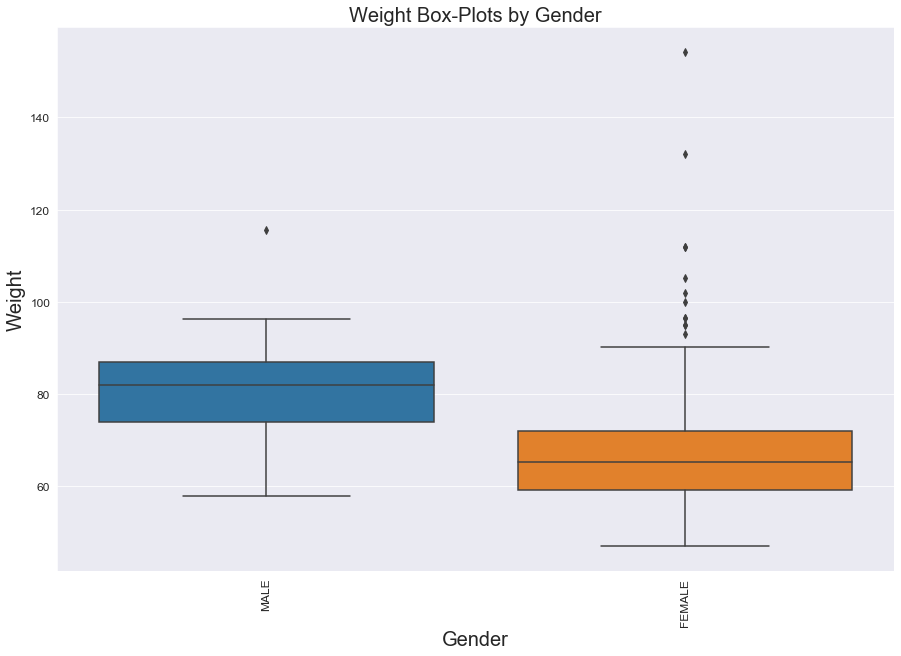

In [48]:
# Box-Plot Weight Distribution by Gender
plt.figure(figsize=[15,10])
sns.boxplot(x = 'gender', y='weight', data = users_df, order = ['MALE', 'FEMALE'])
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Weight Box-Plots by Gender', fontsize = 20)
plt.xlabel("Gender", fontsize=20)
plt.ylabel("Weight", fontsize=20)
plt.show()

### Users Height Distributions

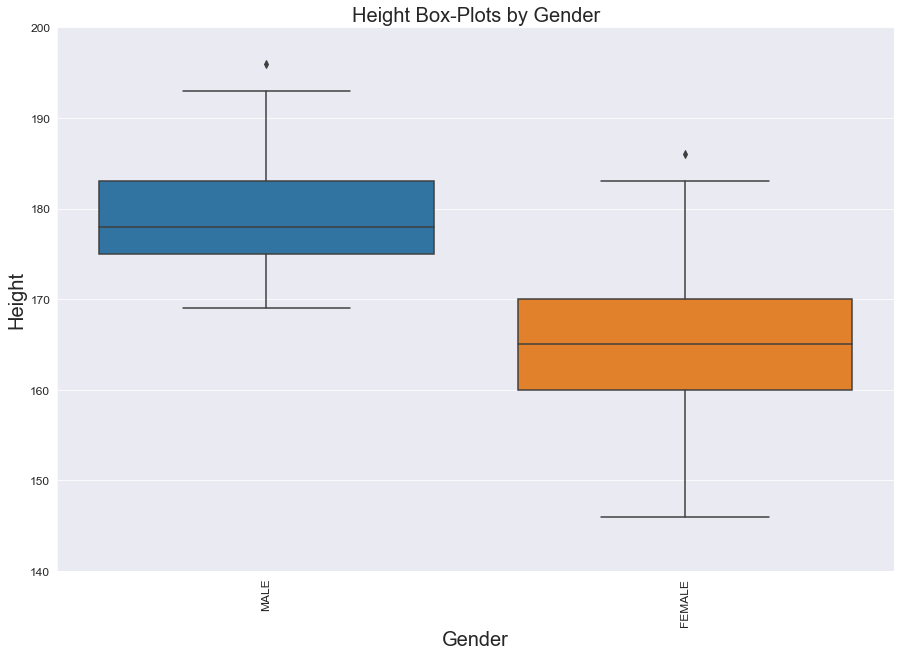

In [49]:
# Box-Plot Height Distribution by Gender
plt.figure(figsize=[15,10])
sns.boxplot(x = 'gender', y='height', data = users_df, order = ['MALE', 'FEMALE'])
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Height Box-Plots by Gender', fontsize = 20)
plt.ylim(140,200)
plt.xlabel("Gender", fontsize=20)
plt.ylabel("Height", fontsize=20)
plt.show()

### Users Age Distributions

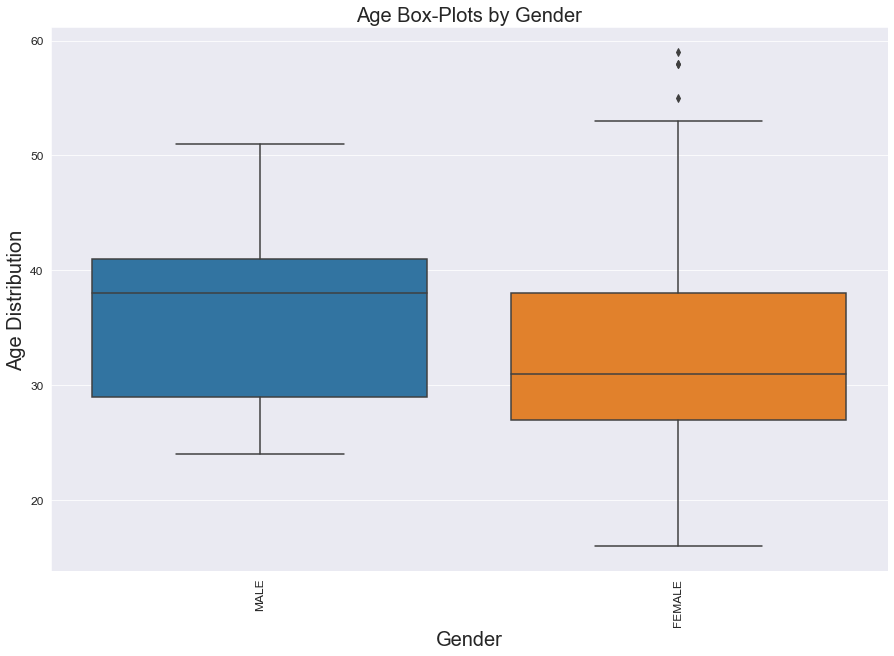

In [50]:
# Box-Plot Height Distribution by Gender
plt.figure(figsize=[15,10])
sns.boxplot(x = 'gender', y='user_age', data = users_df, order = ['MALE', 'FEMALE'])
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Age Box-Plots by Gender', fontsize = 20)
plt.xlabel("Gender", fontsize=20)
plt.ylabel("Age Distribution", fontsize=20)
plt.show()

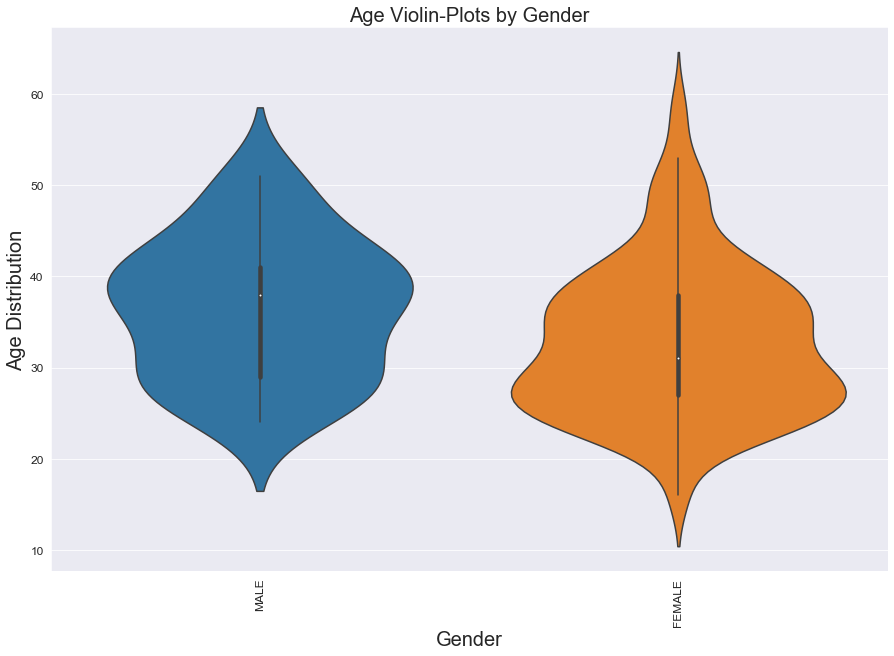

In [51]:
# Box-Plot Height Distribution by Gender
plt.figure(figsize=[15,10])
sns.violinplot(x = 'gender', y='user_age', data = users_df, order = ['MALE', 'FEMALE'])
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Age Violin-Plots by Gender', fontsize = 20)
plt.xlabel("Gender", fontsize=20)
plt.ylabel("Age Distribution", fontsize=20)
plt.show()

### Heart Rate Distributions

- Minimun and maximum heart rate values recorded for different workouts were stored in `heart_df`
- Descriptive statistics are provided using `gender` as discriminant
- Violin plots are also provided to better visualize both `min_recorded_hr` and `max_recorded_hr` distributions
- Both distributions show similar paterns for `MALE` and `FEMALE`

In [52]:
heart_df = df.groupby('workout_id')['user_id','gender','min_recorded_hr', 'max_recorded_hr'].first().dropna()
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40650 entries, 5150 to 4791066
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          40650 non-null  int64  
 1   gender           40650 non-null  object 
 2   min_recorded_hr  40650 non-null  float64
 3   max_recorded_hr  40650 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.6+ MB


/Users/laureanonisenbaum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [53]:
print(heart_df[heart_df.gender == 'FEMALE'].median())
heart_df[heart_df.gender == 'FEMALE'].describe()

user_id            158255.0
min_recorded_hr        77.0
max_recorded_hr       163.0
dtype: float64


,user_id,min_recorded_hr,max_recorded_hr
count,36920.000000,36920.000000,36920.000000
mean,190402.968716,77.243743,152.287947
std,152171.504757,14.986628,30.475211
min,1026.000000,0.000000,44.000000
25%,47417.000000,67.000000,129.000000
50%,158255.000000,77.000000,163.000000
75%,308101.000000,87.000000,176.000000
max,559924.000000,165.000000,229.000000


In [54]:
print(heart_df[heart_df.gender == 'MALE'].median())
heart_df[heart_df.gender == 'MALE'].describe()

user_id            259936.0
min_recorded_hr        75.0
max_recorded_hr       165.0
dtype: float64


,user_id,min_recorded_hr,max_recorded_hr
count,3730.000000,3730.000000,3730.000000
mean,281531.215550,76.006971,152.524129
std,134610.199382,16.781049,33.806440
min,63116.000000,36.000000,46.000000
25%,165166.000000,65.000000,128.000000
50%,259936.000000,75.000000,165.000000
75%,424649.000000,85.000000,177.000000
max,551438.000000,162.000000,223.000000


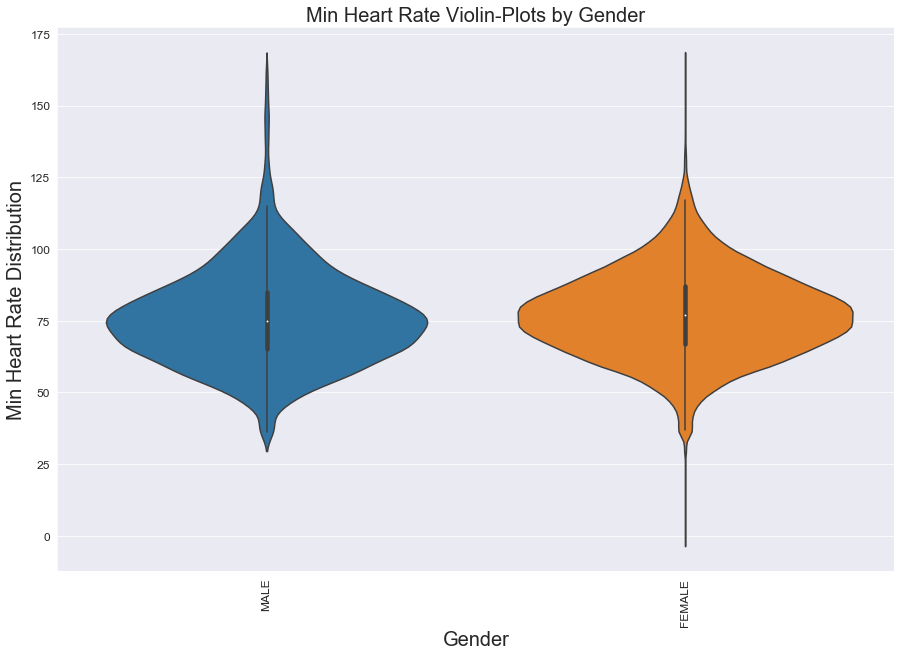

In [55]:
# Box-Plot Height Distribution by Gender
plt.figure(figsize=[15,10])
sns.violinplot(x = 'gender', y='min_recorded_hr', data = heart_df, order = ['MALE', 'FEMALE'])
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Min Heart Rate Violin-Plots by Gender', fontsize = 20)
plt.xlabel("Gender", fontsize=20)
plt.ylabel("Min Heart Rate Distribution", fontsize=20)
plt.show()

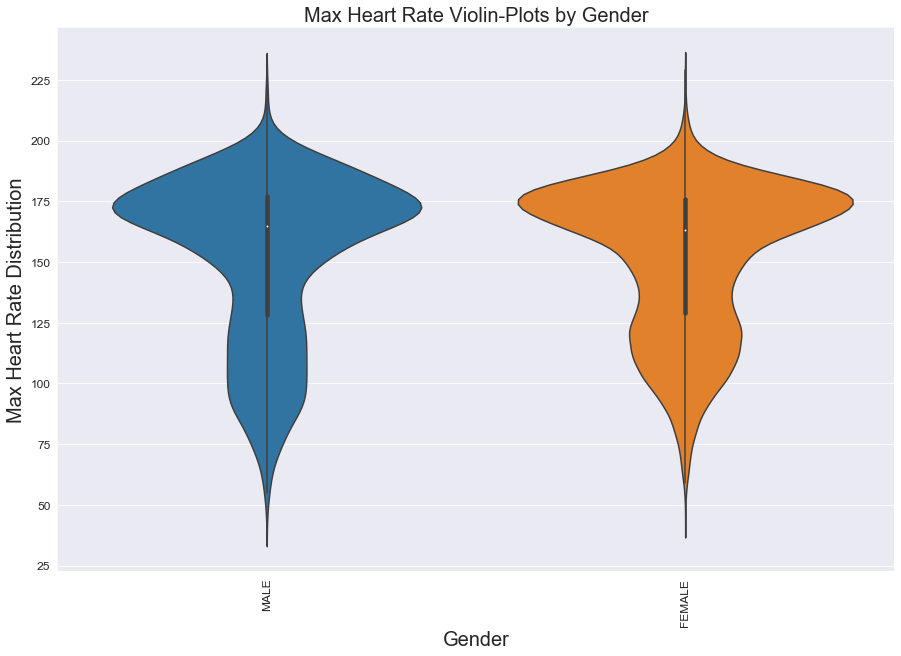

In [56]:
# Box-Plot Height Distribution by Gender
plt.figure(figsize=[15,10])
sns.violinplot(x = 'gender', y='max_recorded_hr', data = heart_df, order = ['MALE', 'FEMALE'])
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Max Heart Rate Violin-Plots by Gender', fontsize = 20)
plt.xlabel("Gender", fontsize=20)
plt.ylabel("Max Heart Rate Distribution", fontsize=20)
plt.show()